In [1]:
import torch

In [2]:
import numpy as np
import csv
import random
import math
import matplotlib

import matplotlib.pyplot as plt

%matplotlib inline

#import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import copy
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torch.optim as optim
from torch import utils
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
use_cuda = torch.cuda.is_available()
CUDA_LAUNCH_BLOCKING=1
#torch.autograd.set_detect_anomaly(True)
print (use_cuda)
torch.cuda.set_device(0)

torch.backends.cudnn.enabled
import os

import sigopt
import time

True


/home/james/miniconda3/envs/james_mlmat/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
from ase import Atoms
from ase.calculators.emt import EMT
from ase.db import connect


from clease.tools import update_db
from clease import Concentration
from clease import CEBulk
from clease import Evaluate
from clease import NewStructures
from clease.calculator import Clease
from clease.calculator import attach_calculator

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

import json
with open('ECI_CuAu_Final_Submission.json') as json_file: 
    eci = json.load(json_file) 
    
conc = Concentration(basis_elements=[['Au', 'Cu']])
settings = CEBulk(crystalstructure='fcc',
                   a=3.8,
                   size=[8,4,4],
                   concentration=conc,
                   db_name="aucu_metals_Final_Submission.db",
                   max_cluster_size=4,
                   max_cluster_dia=[6.0, 4.5, 4.5])

atoms = settings.atoms.copy()
atoms = attach_calculator(settings, atoms=atoms, eci=eci)

gmeans = np.linspace(0,1,51)
gmeans_ten = torch.tensor(gmeans).cuda()

k_b = 0.00008617

def get_concentrations(lattices):
    lattices = ((lattices+1)/2).view(lattices.shape[0],-1)
    Au_conc = torch.sum(lattices,dim=1)/128
    return Au_conc

In [4]:
###### Based off Wu et Al. Solving Statistical Mechanics Using Variational Autoregressive Networks


def KL_loss(DBG,lattices,epoch,temp,field,num_temps,num_fields):
    lattices = lattices.detach()
    probs = DBG.get_sample_prob(lattices,temp,field,epoch).view(lattices.shape[0])
    with torch.no_grad():
        energies = DBG.get_energies(lattices).view(lattices.shape[0])
        energies_norm = energies.view(-1)/(temp.view(-1)*k_b)
        #print(probs.mean())
        F = (energies_norm + probs).view(-1,1)
        F_new = F - (field.view(-1,1) * lattices.view(-1,DBG.Nz).sum(dim=1).view(-1,1))/(k_b*temp.view(-1,1))
        
        batch = int(lattices.shape[0]/(num_temps*num_fields))
        F_mean = F_new.view(-1,num_fields).view(num_temps,-1,num_fields)
        #if epoch%100 == 0:
            #print(F_mean.shape)
        F_mean = F_mean.mean(dim=1).view(num_temps,1,num_fields).expand(num_temps,batch,num_fields)
        R = (F_new.view(-1) - F_mean.reshape(-1))/torch.abs(F_mean.reshape(-1))
        
    #print(energies_norm.mean())
    assert not R.requires_grad
    assert probs.requires_grad
    return torch.mean(R*probs)

In [5]:
temps_sim = [200,450,700,950,1200]
field_sim = [-0.10,-0.04,0.0,0.04,0.10]
temp_temp = [0]
field_temp = [0]
coordinate_cutoff = 4.0
def train_model(model,optimizer,batch_size,epochs,temp_type,chem_type,temp_range):
    field_sim = [-0.08416,-0.04208,0.0,0.028125,0.05625]
    if temp_range == 'Large':
        temps_sim = [200,450,700,950,1200]
    else:
        temps_sim = [200,450,700,950,1200]
    epoch = 0
    temp = torch.zeros(len(temps_sim)*batch_size).cuda()
    field = torch.zeros(len(temps_sim)*batch_size).cuda()

    print_log_header()

    while epoch < epochs:
        if temp_type == 'Random Single':
            num_temps = 1
            t = temps_sim[0] + (temps_sim[-1]-temps_sim[0])*np.random.rand()
            for i in range(len(temps_sim)*batch_size):
                temp[i] = t
        elif temp_type == 'Random':
            t_fixed = []
            for i in range(5):
                t_temp = temps_sim[0] + (temps_sim[-1]-temps_sim[0])*np.random.rand()
                t_fixed.append(t_temp)
            num_temps = 5
            for i in range(len(temps_sim)*batch_size):
                temp[i] = t_fixed[int(i/batch_size)]
        else:
            num_temps = 5
            for i in range(len(temps_sim)*batch_size):
                temp[i] = temps_sim[int(i/batch_size)]
            
        if chem_type == 'Random Single':
            num_fields = 1
            f = -0.1 * 0.20*np.random.rand()
            for i in range(len(temps_sim)*batch_size):
                field[i] = f
        elif chem_type == 'Random':
            f_fixed = []
            for i in range(5):
                f_temp = -0.10 * 0.20*np.random.rand()
                f_fixed.append(f_temp)
            num_fields = 5
            for i in range(len(temps_sim)*batch_size):
                field[i] = f_fixed[int(i%(len(field_sim)))]
        else:
            num_fields = 5
            for i in range(len(temps_sim)*batch_size):
                field[i] = field_sim[int(i%(len(field_sim)))]

        epoch = epoch + 1

        lattices = model.forward(temp,field)
        
        
        kl_loss = KL_loss(model,lattices,epoch,temp,field,num_temps,num_fields)
        
        optimizer.zero_grad()
        kl_loss.backward()
        optimizer.step()
            
       
    return model

In [6]:
def print_log_header():
    print ('{:>8} {:>12}'\
       .format('epoch','train loss'))
    
def print_training_log(epoch, train_loss, test_loss=None):
    if test_loss is not None:
        print ('{:>8} {:>8} {:>12.4f} {:>12.4f}'\
                   .format(epoch, train_loss, test_loss))
        f.write('{:>8} {:>8} {:>12.4f} {:>12.4f}\n'\
                   .format(epoch, train_loss, test_loss))
    else:
        print ('{:>8} {:>8}'\
                   .format(epoch, train_loss))

In [14]:
def one_hot_to_sites(lattices,Nz):
    lattices = lattices.view(-1,Nz,2)
    lattices = torch.argmax(lattices,dim=2)
    lattices = 2*lattices - 1.0
    lattices = lattices.view(-1,Nz)
    return lattices.float()
    
def sites_to_one_hot(lattices):
    lattices = lattices.view(lattices.shape[0],-1)
    lattices = (0.5*(lattices + 1)).long()
    one_hot_lattices = torch.zeros(lattices.shape[0],lattices.shape[1],2).float().cuda()
    one_hot_lattices = one_hot_lattices.scatter_(2,lattices.view(lattices.shape[0],-1,1),1.0)
    return one_hot_lattices.detach()

In [7]:
def mask_weight(m,disp):
    num_sites = m.shape[1]
    num_components = 2
    mask = torch.zeros(m.shape)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            if (disp == 0):
                if (j == 0 or j == 1 ):
                    mask[i,j] = 1.0
                elif ((j-2) < num_components*int(i/num_components) ):
                    mask[i,j] = 1.0
            if (disp == 1):
                if (j == 0 or j==1 ):
                    mask[i,j] = 1.0
                if ((j-2) < num_components*int(i/num_components) + num_components):
                    mask[i,j] = 1.0
    mask = mask.detach()
    m_masked = m*mask
    return m_masked

# Zero out gradients
def get_zero_grad_hook(mask):
    def hook(grad):
        return grad * mask
    return hook

In [8]:
class autoreg_model(nn.Module):
    def __init__(self,Nz,assignments):
        super().__init__()
        self.Nz = Nz
        self.Dim = int(math.sqrt(Nz))
        self.assignments = assignments
        self.activation = activation_functions[assignments['activation']]
        self.lsoftmax = torch.nn.LogSoftmax(dim=2)
        self.softmax = torch.nn.Softmax(dim=2)
        self.num_layers = int(assignments['Layers'])
        self.shared_layer = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer.weight,0))
        self.mask_1 = mask_weight(torch.ones_like(self.shared_layer.weight),0).cuda()
        self.shared_layer.weight.register_hook(get_zero_grad_hook(self.mask_1))
        
        self.shared_layer_2 = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer_2.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer_2.weight,1))
        self.mask_2 = mask_weight(torch.ones_like(self.shared_layer_2.weight),1).cuda()

        self.shared_layer_2.weight.register_hook(get_zero_grad_hook(self.mask_2))
        
        self.shared_layer_3 = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer_3.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer_3.weight,1))
        self.mask_3 = mask_weight(torch.ones_like(self.shared_layer_3.weight),1).cuda()
        self.shared_layer_3.weight.register_hook(get_zero_grad_hook(self.mask_3))
        
        self.shared_layer_4 = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer_4.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer_4.weight,1))
        self.mask_4 = mask_weight(torch.ones_like(self.shared_layer_4.weight),1).cuda()
        self.shared_layer_4.weight.register_hook(get_zero_grad_hook(self.mask_4))
        
    def get_sample_prob(self,lattices,temp,field,epoch):
        
        batch_size = temp.shape[0]
        samples = sites_to_one_hot(lattices).view(batch_size,-1)
        net_in = torch.cat((field.view(-1,1)*10,samples),dim=1)
        net_in = torch.cat((temp.view(-1,1)/1000,net_in),dim=1)
        conditional = self.activation(self.shared_layer(net_in))
        conditional = torch.cat((field.view(-1,1)*10,conditional),dim=1)
        conditional = torch.cat((temp.view(-1,1)/1000,conditional),dim=1)
        conditional = self.shared_layer_2(conditional)
        if self.num_layers > 2:
            conditional = self.activation(conditional)
            conditional = torch.cat((field.view(-1,1)*10,conditional),dim=1)
            conditional = torch.cat((temp.view(-1,1)/1000,conditional),dim=1)
            conditional = self.shared_layer_3(conditional)
            
        if self.num_layers > 3:
            conditional = self.activation(conditional)
            conditional = torch.cat((field.view(-1,1)*10,conditional),dim=1)
            conditional = torch.cat((temp.view(-1,1)/1000,conditional),dim=1)
            conditional = self.shared_layer_4(conditional)
        
        
        
        
        conditional = conditional.view(-1,self.Nz,2)

        Probs = self.lsoftmax(conditional)

        samples = samples.detach()

        assert Probs.requires_grad == True
        site_prob = Probs*(samples.view(-1,self.Nz,2))
        probs = torch.sum(torch.sum(site_prob,dim=2),dim=1)
        return probs
        
    def forward(self,temp,field):
        
        batch_size = temp.shape[0]
        temp = temp.view(-1,1)
        field = field.view(-1,1)
        lattices = torch.zeros(batch_size,2*self.Nz).cuda()
        for site in range(self.Nz):
            net_in = torch.cat((field*10,lattices),dim=1)
            net_in = torch.cat((temp/1000,net_in),dim=1)
            conditional = self.activation(self.shared_layer(net_in))
            conditional = torch.cat((field*10,conditional),dim=1)
            conditional = torch.cat((temp/1000,conditional),dim=1)
            conditional = self.shared_layer_2(conditional)
            if self.num_layers > 2:
                conditional = self.activation(conditional)
                conditional = torch.cat((field.view(-1,1)*10,conditional),dim=1)
                conditional = torch.cat((temp.view(-1,1)/1000,conditional),dim=1)
                conditional = self.shared_layer_3(conditional)
            
            if self.num_layers > 3:
                conditional = self.activation(conditional)
                conditional = torch.cat((field.view(-1,1)*10,conditional),dim=1)
                conditional = torch.cat((temp.view(-1,1)/1000,conditional),dim=1)
                conditional = self.shared_layer_4(conditional)
            
            conditional = conditional.view(-1,self.Nz,2)
            Probs = self.softmax(conditional)
            To_Sample = Probs[:,site,:]
            sample = torch.multinomial(To_Sample,1).view(-1,1)
            lattices = lattices.view(-1,self.Nz,2)
            lattices[:,site,:] = lattices[:,site,:].scatter_(1,sample,1)
            lattices = lattices.view(-1,2*self.Nz)

        lattices = one_hot_to_sites(lattices,self.Nz)
        return lattices

def create_model(Nz,assignments):
    class Discrete_Boltzmann_Generator(nn.Module):
        def __init__(self,Nz,assignments):
            super().__init__()
            self.Nz = Nz
            self.Dim = int(math.sqrt(Nz))
            self.assignment = assignments
            self.Model = autoreg_model(Nz,assignments)
            atoms.numbers = np.ones((self.Nz))*29
            self.U_cu = atoms.get_potential_energy()
            atoms.numbers = np.ones((self.Nz))*79
            self.U_au = atoms.get_potential_energy()
            
        def forward(self,temp,field):
            return self.Model.forward(temp,field)
            
        def get_energies(self,lattices):
            lattices = lattices.view(lattices.shape[0],-1)
            energies = torch.zeros(lattices.shape[0]).cuda()
            for lattice_num in range(lattices.shape[0]):
                energies[lattice_num] = self.get_cluster_energy(lattices[lattice_num,:])
            #print(energies)
            return energies
        
        def get_cluster_energy(self,lattice):
            ## Cu = 28
            ## Au = 79
            atoms.numbers = ((lattice*25)+54).int().cpu().detach().numpy()
            energy_t = atoms.get_potential_energy()
            lattice = ((lattice+1)/2).view(-1)
            Au_conc = torch.sum(lattice,dim=0)/(self.Nz)
            energy_t = energy_t - (1-Au_conc)*(self.U_cu) - (Au_conc)*(self.U_au)

            return energy_t
        
        def get_sample_prob(self,sample,temp,field,epoch):
            return self.Model.get_sample_prob(sample,temp,field,epoch)
        
    model = Discrete_Boltzmann_Generator(Nz,assignments).cuda()
    temp_range = assignments['temp_range']
    batch_size = int(assignments['batch_size'])
    optimizer = optimizers[assignments['optimizer']](model.parameters(), lr=10**assignments['log_learning_rate'])
    epochs = assignments['epochs']
    temp_type = assignments['temp_type']
    chem_type = assignments['Chem_type']
    model = train_model(model,optimizer,batch_size,epochs,temp_type,chem_type,temp_range)
    
    return model

In [9]:
class Discrete_Boltzmann_Generator(nn.Module):
        def __init__(self,Nz,assignments):
            super().__init__()
            self.Nz = Nz
            self.Dim = int(math.sqrt(Nz))
            self.assignment = assignments
            self.Model = autoreg_model(Nz,assignments)
            atoms.numbers = np.ones((self.Nz))*29
            self.U_cu = atoms.get_potential_energy()
            atoms.numbers = np.ones((self.Nz))*79
            self.U_au = atoms.get_potential_energy()
            
        def forward(self,temp,field):
            return self.Model.forward(temp,field)
            
        def get_energies(self,lattices):
            lattices = lattices.view(lattices.shape[0],-1)
            energies = torch.zeros(lattices.shape[0]).cuda()
            for lattice_num in range(lattices.shape[0]):
                energies[lattice_num] = self.get_cluster_energy(lattices[lattice_num,:])
 
            return energies
        
        def get_cluster_energy(self,lattice):
            ## Cu = 28
            ## Au = 79
            atoms.numbers = ((lattice*25)+54).int().cpu().detach().numpy()
            energy_t = atoms.get_potential_energy()
            lattice = ((lattice+1)/2).view(-1)
            Au_conc = torch.sum(lattice,dim=0)/(self.Nz)
            energy_t = energy_t - (1-Au_conc)*(self.U_cu) - (Au_conc)*(self.U_au)

            return energy_t
        
        def get_sample_prob(self,sample,temp,field,epoch):
            return self.Model.get_sample_prob(sample,temp,field,epoch)

In [10]:
activation_functions = {
    'relu': nn.ReLU(),
    'sigmoid': nn.Sigmoid(),
    'tanh': nn.Tanh(),
}

optimizers = {
    'gradient_descent': optim.SGD,
    'rmsprop': optim.RMSprop,
    'adam': optim.Adam,
}


Dim = 5

In [13]:
def get_Ness(model,lattices,tmp,temp_b,field_b):
    size = lattices.shape[0]
    iters = int(size/1000)
    lattices = lattices.view(-1,iters,125)
    for i in range(iters):
        energies = (model.get_energies(lattices[:,i,:])/(tmp*k_b)).view(-1)
        prob = model.get_sample_prob(lattices[:,i,:],temp_b,field_b,1000).view(-1)
        temp_pot = -(field_b.view(-1)*lattices[:,i,:].sum(dim=1).view(-1))/(tmp*k_b)
        temp_pot = energies+prob+temp_pot
        if i ==0:
            pot = temp_pot
        else:
            pot = torch.cat((pot,temp_pot),dim=0)
    log_rw = -pot
    log_rw = log_rw - log_rw.mean()
    log_rw = log_rw.view(-1)
    Top_term = 2*torch.logsumexp(log_rw,dim=0)
    Bottom_term = torch.logsumexp(2*log_rw,dim=0)
    Log_Ness = Top_term - Bottom_term
    return torch.exp(Log_Ness)

In [41]:
from sigopt import Connection
import socket

#conn = Connection(client_token="RAFA GB Token")
experiment_id = 357554
assignments = conn.experiments(experiment_id).best_assignments().fetch().data[0].assignments


In [11]:
assignments = {
  "Chem_type": "Fixed",
  "Layers": "3",
  "activation": "sigmoid",
  "batch_size": "300",
  "epochs": 17228.762093926078,
  "log_learning_rate": -2.524528017542186,
  "optimizer": "adam",
  "temp_range": "Small",
  "temp_type": "Random"
}

In [12]:
print(assignments)

{'Chem_type': 'Fixed', 'Layers': '3', 'activation': 'sigmoid', 'batch_size': '300', 'epochs': 17228.762093926078, 'log_learning_rate': -2.524528017542186, 'optimizer': 'adam', 'temp_range': 'Small', 'temp_type': 'Random'}


In [ ]:
model = create_model(128,assignments)

   epoch   train loss


In [24]:
print(model)


Discrete_Boltzmann_Generator(
  (Model): autoreg_model(
    (activation): Tanh()
    (lsoftmax): LogSoftmax(dim=2)
    (softmax): Softmax(dim=2)
    (shared_layer): Linear(in_features=258, out_features=256, bias=False)
    (shared_layer_2): Linear(in_features=258, out_features=256, bias=False)
    (shared_layer_3): Linear(in_features=258, out_features=256, bias=False)
    (shared_layer_4): Linear(in_features=258, out_features=256, bias=False)
  )
)


In [ ]:
torch.save(model.state_dict(), "CuAu_128_Final_Submission")

In [ ]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#003f5c
#58508d
#bc5090
#ff6361
#ffa600
N = 5
newcolors = []
newcolors.append((0,63,92))
newcolors.append((88,80,141)) 
newcolors.append((188,80,144)) 
newcolors.append((255,99,97)) 
newcolors.append((255,166,0)) 

newcolors_norm = []
for i in newcolors:
    curr = np.asarray(i)
    print(curr)
    curr = curr/255.0
    curr = tuple(curr)
    newcolors_norm.append(curr)

cmap_name = 'my_list'
newcmp = LinearSegmentedColormap.from_list(cmap_name,newcolors_norm)

In [ ]:
def examine_phase(model,lattices,tmp,temp_b,field_b,Au_conc):
    #print(lattices)
    prob = model.get_sample_prob(lattices,temp_b,field_b,1000).view(-1)
    with torch.no_grad():
        
        energies = (model.get_energies(lattices)/(tmp*k_b)).view(-1)
        
        
        pot = -(field_b.view(-1)*lattices.sum(dim=1).view(-1))/(tmp*k_b)
        pot = energies+prob+pot
        log_rw = -pot
        stored = log_rw.mean()
        log_rw_corr = log_rw - stored
        rw = torch.exp(log_rw_corr)
        rw_norm = rw/(rw.sum())
        est_part = torch.exp(log_rw_corr).mean()
        log_z = torch.log(est_part)+stored
        conc_mean = (Au_conc.view(-1)*rw_norm.view(-1)).sum().cpu().detach().numpy().item()
        gp = -k_b*tmp*log_z
        
        
        energies_ev = (energies*k_b*tmp*rw_norm).sum()
        energies_sqrd_ev = (((energies*k_b*tmp)**2)*rw_norm).sum()
        
        hc = (energies_sqrd_ev - energies_ev**2)/(k_b*tmp**2)
        
    return conc_mean,gp,hc

In [ ]:
def get_conc_at_temp(temp):
    
    chemical_pots = np.linspace(-.1,.075,36)
    concs_rw = np.linspace(-.1,.075,36)
    gps = np.linspace(-.1,.075,36)
    heat_caps = np.linspace(-.1,.075,36)
    temps = torch.zeros(5000).cuda()
    counter = 0
    for chpot in chemical_pots:
        temps = torch.zeros(5000).cuda()
        fields = torch.zeros(5000).cuda()
        for i in range(5000):
            temps[i] = temp
            fields[i] = chpot
            
        lattices = model.forward(temps,fields)
        concs_iter = get_concentrations(lattices).view(-1)
        
        conc_mean,gp,hc = examine_phase(model,lattices,temp,temps,fields,concs_iter)
        gps[counter] = gp.cpu().detach().numpy()
        heat_caps[counter] = hc.cpu().detach().numpy()
        concs_rw[counter] = conc_mean
        counter = counter + 1
        
    return chemical_pots,concs_rw,gps,heat_caps

In [ ]:
CuAu_data_concs = np.zeros((21,36))
CuAu_data_gp = np.zeros((21,36))
CuAu_data_hc = np.zeros((21,36))

temps_study = np.linspace(200,1200,21)

pos = 0
for t in temps_study:
    print("start")
    chemical_pots,concs_rw,gp,hc = get_conc_at_temp(t)
    CuAu_data_concs[pos,:] = concs_rw
    CuAu_data_gp[pos,:] = gp
    CuAu_data_hc[pos,:] = hc
    pos+=1

In [ ]:
np.savetxt("CuAu_AR_128_final_submission_concs.csv", CuAu_data_concs, delimiter=",")
np.savetxt("CuAu_AR_128_final_submission_gp.csv", CuAu_data_gp, delimiter=",")
np.savetxt("CuAu_AR_128_final_submission_hc.csv", CuAu_data_hc, delimiter=",")

In [31]:
def get_Ness(model,lattices,tmp,temp_b,field_b):
    size = lattices.shape[0]
    iters = int(size/1000)
    lattices = lattices.view(-1,iters,128)
    for i in range(iters):
        energies = (model.get_energies(lattices[:,i,:])/(tmp*k_b)).view(-1)
        prob = model.get_sample_prob(lattices[:,i,:],temp_b,field_b,1000).view(-1)
        temp_pot = -(field_b.view(-1)*lattices[:,i,:].sum(dim=1).view(-1))/(tmp*k_b)
        temp_pot = energies+prob+temp_pot
        if i ==0:
            pot = temp_pot
        else:
            pot = torch.cat((pot,temp_pot),dim=0)
    log_rw = -pot
    log_rw = log_rw - log_rw.mean()
    log_rw = log_rw.view(-1)
    Top_term = 2*torch.logsumexp(log_rw,dim=0)
    Bottom_term = torch.logsumexp(2*log_rw,dim=0)
    Log_Ness = Top_term - Bottom_term
    return torch.exp(Log_Ness)

In [32]:
chem_p = np.linspace(-0.1,0.075,36)
temps = np.linspace(200,1200,21)
num = 10000
temps_f = torch.zeros(1000).cuda()
ch_p_f = torch.zeros(1000).cuda()
Ness = np.zeros((temps.shape[0],chem_p.shape[0]))
for i in range(temps.shape[0]):
    for j in range(chem_p.shape[0]):
        for m in range(10):
            for k in range(1000):
                temps_f[k] = temps[i]
                ch_p_f[k] = chem_p[j]
            temp_lattices = model.forward(temps_f,ch_p_f)
            if m ==0:
                lattices = temp_lattices
            else:
                lattices = torch.cat((lattices,temp_lattices),dim=0)
        N_temp = get_Ness(model,lattices,temps[i],temps_f,ch_p_f)
        Ness[i,j] = N_temp/num
        print("done")

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


In [33]:
np.save("CuAu_128_NESS_data_final_submission", Ness)

In [79]:
temps_below = np.linspace(200,700,6)
print(temps_below)
plotter_concs_mid = []
plotter_temps_mid = []

counter = 0
for temp in temps_below:
    ind = 2* counter
    
    
    curr_concs = CuAu_data_concs[ind,:]
    max_ind = -1
    max_split = -1
    for j in range(1,len(curr_concs)-1):
        if curr_concs[j-1] > 0.2 and curr_concs[j+1] < 0.6:
            if curr_concs[j+1] - curr_concs[j-1] > max_split:
                max_split = curr_concs[j+1] - curr_concs[j-1]
                max_ind = j
                
    counter += 1
    print(max_split)
    
    new_concs = [curr_concs[max_ind-1],curr_concs[max_ind+1]]
    new_temps = [temp,temp]
    
    plotter_concs_mid.append(new_concs)
    plotter_temps_mid.append(new_temps)

[200. 300. 400. 500. 600. 700.]
0.249999538064003
0.24201449751853943
0.2405618131160736
0.2392224669456482
0.21986639499664307
0.18202880024909973


In [80]:
dat_temps =[]
dat_pots = []
chemical_pots = np.linspace(-.1,.075,36)
temps_study = np.linspace(200,1200,21)
plotter_temps = []
plotter_concs = []
insides = []

storer = []

for i in range(36):
    
    
    if True:    
        
        max_ind = -1
        curr = -100000000
        for j in range(2,CuAu_data_hc.shape[0]):
            if CuAu_data_hc[j,i]> curr:
                curr = CuAu_data_hc[j,i]
                max_ind = j

        dat_pots.append(chemical_pots[i])
        dat_temps.append(temps_study[max_ind])

        if i > 5 and i < 28:
            storer.append(max_ind)
            plotter_temps.append([temps_study[max_ind],temps_study[max_ind]])
            plotter_concs.append([CuAu_data_concs[max_ind,i-1],CuAu_data_concs[max_ind,i+1]])
            insides.append(CuAu_data_concs[max_ind,i])
            
        else:
            storer.append(0)
    
print(temps_study)

[ 200.  250.  300.  350.  400.  450.  500.  550.  600.  650.  700.  750.
  800.  850.  900.  950. 1000. 1050. 1100. 1150. 1200.]


No handles with labels found to put in legend.


[(0.006030428688973188, 400.0), (0.041283607482910156, 550.0), (0.09822313487529755, 650.0), (0.1389545202255249, 750.0), (0.18339577317237854, 750.0), (0.2193146049976349, 750.0), (0.2193146049976349, 750.0), (0.2354230284690857, 800.0), (0.2619350552558899, 800.0), (0.2746598720550537, 800.0), (0.31504279375076294, 800.0), (0.38491177558898926, 750.0), (0.41118836402893066, 700.0), (0.41118836402893066, 700.0), (0.46795597672462463, 700.0), (0.46795597672462463, 700.0), (0.5190004110336304, 700.0), (0.5722625255584717, 700.0), (0.5823133587837219, 650.0), (0.6718878149986267, 650.0), (0.7369346022605896, 600.0), (0.8040276765823364, 550.0), (0.8562190532684326, 500.0), (0.9615838527679443, 350.0)]
0.003525317879393697
0.005693952739238739
0.004073138535022733
0.004444125294685364
0.0035918831825256458
-5.551115123125783e-18
0.001610842347145075
0.002651202678680431
0.0012724816799163873
0.004038292169570917
0.006986898183822638
0.002627658843994135
5.551115123125783e-18
0.00567676126

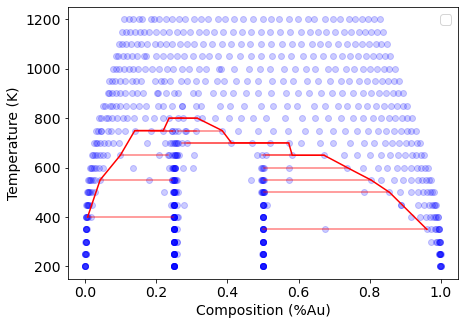

In [81]:
from scipy.spatial import ConvexHull
import matplotlib as mpl

mpl.rc('font',family='Arial')
hfont = {'fontname':'Arial'}

pos = 0
temps_study = np.linspace(200,1200,21)
for t in range(36):

    plt.scatter(CuAu_data_concs[:,t],temps_study,color='blue',alpha=0.2)
    
    pos += 1
    
left_bounds_conc = []
left_bounds_t = []

right_bounds_conc = []
right_bounds_t = []
    
hull_temps = []
hull_points = np.zeros((len(plotter_concs),2))
for i in range(len(plotter_concs)):
    plt.plot(plotter_concs[i],plotter_temps[i],color='red',alpha=0.5)
    
    left_bounds_conc.append(plotter_concs[i][0])
    right_bounds_conc.append(plotter_concs[i][1])
    
    left_bounds_t.append(plotter_temps[i][0])
    right_bounds_t.append(plotter_temps[i][0])
    


########### MAKE TOP #################################################

intervals = {}

for i in range(len(plotter_concs)):
    curr_interval = (plotter_concs[i][0],plotter_concs[i][1])
    intervals[curr_interval] = plotter_temps[i][0]
    
max_points = []

for i in range(len(plotter_concs)):
    curr_a = plotter_concs[i][0]
    curr_b = plotter_concs[i][1]
    val = plotter_temps[i][1]
    
    a_max = True
    for interval in intervals.keys():
        if curr_a > interval[0] and curr_a < interval[1]:
            if val < intervals[interval]:
                a_max = False
                
    b_max = True
    for interval in intervals.keys():
        if curr_b > interval[0] and curr_b < interval[1]:
            if val < intervals[interval]:
                b_max = False
                
    if a_max:
        max_points.append((curr_a,val))
        
    if b_max:
        max_points.append((curr_b,val))
                


max_points.sort()

print(max_points)

path_x = []
path_y = []

curr_x = max_points[0][0]
curr_y = max_points[0][1]
path_x.append(curr_x)
path_y.append(curr_y)
at_point = True
next_point = None
move = [0.0,0.0]
step = 0.0
curr_point = 0
while abs(curr_x - max_points[-1][0]) > 0.00001:
    if at_point:
        #print(curr_x)
        curr_point+=1
        next_point = max_points[curr_point]
        
        
        move[0] = (next_point[0] - curr_x)/10.0
        move[1] = (next_point[1] - curr_y)/10.0
        at_point = False
        print(move[0])
    else:
        curr_x += move[0]
        curr_y += move[1]
        path_x.append(curr_x)
        path_y.append(curr_y)
        
        if abs(curr_x-next_point[0])<0.00001:
            at_point = True
    
plt.plot(path_x,path_y, color='red')


plt.ylabel("Temperature (K)",fontsize=14,**hfont)
plt.xlabel("Composition (%Au)",fontsize=14,**hfont)

plt.xticks(fontsize = 14,fontname = "Arial")
plt.yticks(fontsize = 14,fontname = "Arial")
plt.legend(prop={'family': 'Arial','size':14})
#plt.savefig('CuAuAR_2_june6.png',bbox_inches='tight')

plt.show()






-0.13
0.03999999999999998


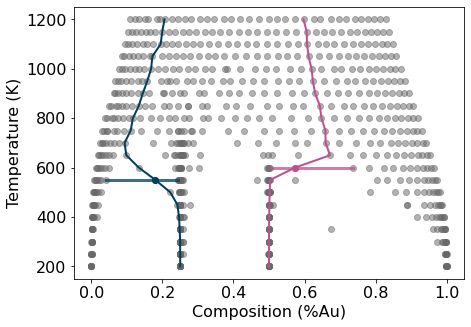

In [82]:
ind = 7
shift=17
chemical_pots = np.linspace(-0.1,0.075,36)
print(2*chemical_pots[ind])
print(2*chemical_pots[ind+shift])

for i in range(36):
    plt.scatter(CuAu_data_concs[:,i],temps_study,color='dimgrey',alpha = 0.5)
    
plt.plot(CuAu_data_concs[:,ind],temps_study,color=newcmp(0.0),linewidth=2.0)
plt.scatter(CuAu_data_concs[storer[ind],ind],temps_study[storer[ind]],color=newcmp(0.0))
bound_x = [CuAu_data_concs[storer[ind],ind-1],CuAu_data_concs[storer[ind],ind+1]]
bound_y = [temps_study[storer[ind]],temps_study[storer[ind]]]
plt.plot(bound_x,bound_y,color=newcmp(0.0),linewidth=3.0,alpha=0.75)

plt.plot(CuAu_data_concs[:,ind+shift],temps_study,color=newcmp(0.5),linewidth=2.0)
plt.scatter(CuAu_data_concs[storer[ind+shift],ind+shift],temps_study[storer[ind+shift]],color=newcmp(0.5))
bound_x = [CuAu_data_concs[storer[ind+shift],ind+shift-1],CuAu_data_concs[storer[ind+shift],ind+shift+1]]

bound_y = [temps_study[storer[ind+shift]],temps_study[storer[ind+shift]]]

plt.plot(bound_x,bound_y,color=newcmp(0.5),linewidth=3.0,alpha=0.75)


plt.ylabel("Temperature (K)",fontsize=16,fontname="Arial")
plt.xlabel("Composition (%Au)",fontsize=16,fontname="Arial")

plt.xticks(fontsize = 16,fontname = "Arial")
plt.yticks(fontsize = 16,fontname = "Arial")
plt.rcParams["figure.figsize"] = (7,5)

plt.savefig('CuAuAR_SI_final_submission.pdf',bbox_inches='tight')


plt.show()

In [83]:
#plotter_temps = np.asarray(plotter_temps)
np.savetxt("plotter_temps_final_submission.csv", plotter_temps, delimiter=",")
#plotter_concs = np.asarray(plotter_concs)

np.savetxt("plotter_concs_final_submission.csv", plotter_concs, delimiter=",")
#path_x = np.asarray(path_x)

np.savetxt("plotter_temps_mid_final_submission.csv", plotter_temps_mid, delimiter=",")
#plotter_concs = np.asarray(plotter_concs)

np.savetxt("plotter_concs_mid_final_submission.csv", plotter_concs_mid, delimiter=",")
#path_x = np.asarray(path_x)

np.savetxt("Top_x_final_submission.csv", path_x, delimiter=",")
#path_y = np.asarray(path_y)
np.savetxt("Top_Y_final_submission.csv", path_y, delimiter=",")

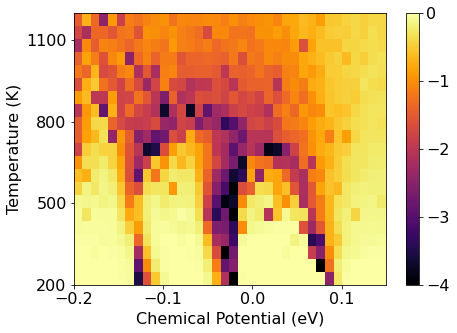

In [77]:
chem_p = np.linspace(-0.1,0.075,36)
temps = np.linspace(200,1200,21)

all_chem_p = []
all_temps = []
for i in range(temps.shape[0]):
    for j in range(chem_p.shape[0]):
        all_temps.append(temps[i])
        all_chem_p.append(2*chem_p[j])
        

plt.hist2d(all_chem_p,all_temps,bins = (36,21), weights = np.log10(Ness).reshape(-1),cmap='inferno',vmin=-4.0,vmax=0.0)
plt.rcParams["figure.figsize"] = (7,5)
plt.xlabel('Chemical Potential (eV)',fontsize=16,**hfont)
plt.ylabel('Temperature (K)',fontsize=16,**hfont)
plt.xticks(fontsize = 16,fontname = "Arial") 
plt.yticks(fontsize = 16,fontname = "Arial") 
plt.yticks([200,500,800,1100])
plt.xticks([-0.2,-0.1,0.0,0.1])

cb = plt.colorbar()

imaxes = plt.gca()
plt.axes(cb.ax)
plt.yticks(fontsize=16,fontname = "Arial")
cb.set_ticks([-4.0,-3.0,-2.0,-1.0,0.0])


plt.savefig("NESS_CuAu_128_final_submission.pdf",bbox_inches='tight')

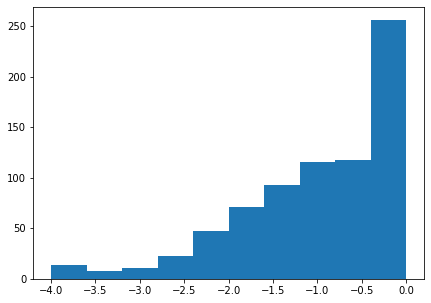

In [78]:
plt.hist(np.log10(Ness).reshape(-1))
plt.show()